# Notebook to make Figs. 3 and 6: spins and mass cornerplot

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import AutoMinorLocator

style.use('plotting.mplstyle')

import seaborn as sns
cp = sns.color_palette('colorblind') 

import sys
sys.path.append('../scripts')
from helper_functions import *

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load data 

Posterior samples

In [2]:
td_samples, tcutoffs = load_posterior_samples(data_dir)

Turn into a dictionary to plot

In [3]:
def get_plotting_dict(samples):
     
    # downsample to speed up plotting
    target_length = 7000
    mask = np.random.choice(len(samples['mtotal']), size=target_length, replace=False)
    
    # get mass samples
    mtot = samples['mtotal'][mask]
    q = samples['q'][mask]
    m1, m2 = m1m2_from_mtotq(mtot, q)
    
    # get chi_eff
    chieff = chi_effective(m1, samples['chi1'][mask], samples['tilt1'][mask],
                                m2, samples['chi2'][mask], samples['tilt2'][mask])
    
    # get chi_p
    chip = chi_precessing(m1, samples['chi1'][mask], samples['tilt1'][mask],
                                m2, samples['chi2'][mask], samples['tilt2'][mask])
    
    return {'chip':chip, 'chieff':chieff, 'mtot':mtot, 'q':q}

In [4]:
# Format samples into dict of what we want to plot

dict_to_plot = {}
for tc in np.concatenate([tcutoffs, ['prior'], ['full']]):
    
    # get samples
    if tc=='full'or tc=='prior':
        dict_to_plot[tc] = get_plotting_dict(td_samples[k])
    else: 
        for r in ['insp', 'rd']: 
            k = f'{r} {tc}'
            try: 
                samples = td_samples[k]
            except: 
                samples = td_samples['prior']
            dict_to_plot[k] = get_plotting_dict(samples)

### More things needed for fig

In [5]:
labels_dict = {'chip':r'$\chi_\mathrm{p}$', 'chieff':r'$\chi_\mathrm{eff}$', 'mtot':r'$M\,[M_\odot]$', 'q':r'$q$'}
bounds_dict = {'chip':(0,1), 'chieff':(-0.8,0.8), 'mtot':(200,400), 'q':(0.18,1)}
tc_lbls = {tc:tc.replace('m', '-') if tc[0]=='m' else tc for tc in tcutoffs}

In [6]:
# Cast strings to floats
tc_floats = {}
for tc_str in tcutoffs:
    if tc_str[0]=='m':
        tc_str_trimmed = tc_str[1:-1]
    else:
        tc_str_trimmed = tc_str[0:-1]     
    tc_float = -1*float(tc_str_trimmed) if tc_str[0]=='m' else float(tc_str_trimmed) 
    tc_floats[tc_str]=tc_float

Make kdes for full and prior runs

In [7]:
# grid on which to evaluate kdes
kde_dict = {}

for run in ['full', 'prior']: 
    
    # get samples
    samples = td_samples[run]
    mtot = samples['mtotal']
    q = samples['q']
    m1, m2 = m1m2_from_mtotq(mtot, q)
    chip = chi_precessing(m1, samples['chi1'], samples['tilt1'],
                          m2, samples['chi2'], samples['tilt2'])
    chieff = chi_effective(m1, samples['chi1'], samples['tilt1'],
                          m2, samples['chi2'], samples['tilt2'])
    
    # make kdes
    chip_grid, chip_kde = reflected_kde(chip, *bounds_dict['chip'])
    chieff_grid, chieff_kde = reflected_kde(chieff, *bounds_dict['chieff'])
    q_grid, q_kde = reflected_kde(q, *bounds_dict['q'])
    mtot_grid, mtot_kde = reflected_kde(mtot, *bounds_dict['mtot'])
    
    kde_dict[run] = {
        'chip':{'kde':chip_kde, 'grid':chip_grid}, 
        'chieff':{'kde':chieff_kde, 'grid':chieff_grid}, 
        'q':{'kde':q_kde, 'grid':q_grid}, 
        'mtot':{'kde':mtot_kde, 'grid':mtot_grid}, 
    }

### Make figure

In [25]:
def make_hist(keys, tc_to_plot, savename, pre_or_post, bins = 30, labelsize = 15, colors=None,
              legend_loc=(-0.6, 2.35), fig_size=None, shade=True):
    
    err_msg = f'pre_or_post cannot be {pre_or_post}'
    assert pre_or_post == 'pre' or pre_or_post == 'post', err_msg
    
    if pre_or_post == 'pre':
        run = 'insp'
    else: 
        run = 'rd'
    
    # numbers of parameters we are plotting
    ndim = len(keys)
    
    # colors for each run to plot
    if colors == None: 
        colors = [cp[i] for i,tc in enumerate(tc_to_plot)]
    else: 
        assert len(colors)==len(tc_to_plot), f'{len(colors)} colors given for {len(tc_to_plot)} tc values'
        
    if fig_size is None: 
        fig_size = (ndim*2,ndim*2)
    fig = plt.figure(figsize=fig_size)

    for i,key in enumerate(keys):

        # Plot the marginal 1D posterior(s) (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))

        bounds = bounds_dict[key]

        # Cycle through each tc and plot the posterior samples
        for r,tc in enumerate(tc_to_plot):

            posterior = dict_to_plot[f'{run} {tc}'][key]
            ax.hist(posterior,bins=np.linspace(*bounds,bins), rasterized=True, density=True, zorder=1, 
                    histtype='step', color=colors[r], lw=1.5)
            
            if tc == 'm10M' and shade: 
                ax.hist(posterior,bins=np.linspace(*bounds,bins), rasterized=True, density=True, zorder=0, 
                    histtype='stepfilled', color=colors[r], alpha=0.2, lw=1.5)

        # Add full posterior and prior
        ax.plot(kde_dict['full'][key]['grid'], kde_dict['full'][key]['kde'], color='k')
        if key=='q' or key=='mtot': 
            # uniform priors
            ax.axhline(1/(bounds_dict[key][1] - bounds_dict[key][0]), color='k', ls=':')
        else:
            ax.plot(kde_dict['prior'][key]['grid'], kde_dict['prior'][key]['kde'], color='k', ls=':')

        # Set axis bounds
        ax.set_xlim(*bounds)

        # Turn off tick
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.set_yticklabels([])
        ax.grid(visible=True, axis='x', which='both')
        ax.grid(visible=False, axis='y', which='both')

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(labels_dict[key],fontsize=labelsize)

        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:

            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):

                # Make a 2D contour plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))

                # Axes bounds
                x_bounds = bounds_dict[key]
                y_bounds = bounds_dict[k]

                # Cycle through each run and plot the posterior samples
                for r,tc in enumerate(tc_to_plot):

                    posterior_x = dict_to_plot[f'{run} {tc}'][key]
                    posterior_y = dict_to_plot[f'{run} {tc}'][k]
                    posterior_df = pd.DataFrame({key:posterior_x, k:posterior_y})

                    # Use seaborn to make a kde plot
                    sns.kdeplot(data=posterior_df, 
                                x=key, y=k,
                                ax=ax, 
                                levels=[0.5],
                                fill=False,
                                zorder=5-r, 
                                color=colors[int(r)]
                    )
                    
                # Set axis bounds
                ax.set_xlim(*x_bounds)
                ax.set_ylim(*y_bounds)
                ax.xaxis.set_minor_locator(AutoMinorLocator(2))
                ax.yaxis.set_minor_locator(AutoMinorLocator(2))
                ax.grid(True,which='both',dashes=(1,3))

                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(labels_dict[k],fontsize=labelsize)
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(labels_dict[key],fontsize=labelsize)
                else:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])

    # Legend
    handles = [Line2D([], [], color=colors[r], 
        label=f'$\mathrm{{{pre_or_post}}}$-$t = {tc_lbls[tc][:-1]}\,M_\mathrm{{ref}}$') for r,tc in enumerate(tc_to_plot)]
    legend1 = plt.legend(handles=handles, loc='lower left', fontsize=14, bbox_to_anchor=legend_loc, 
                        handlelength=1.5)
    handles2 = [Line2D([], [], color='k',label=r'$\mathrm{full}$'), 
                Line2D([], [], color='k', ls=':', label=r'$\mathrm{prior}$')]
    legend2 = plt.legend(handles=handles2, loc='lower left', fontsize=14, 
                         bbox_to_anchor=(legend_loc[0], legend_loc[1]-0.2), ncol=2, 
                        handlelength=1.5)
        
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    for i, h in enumerate(handles):
        legend1.get_lines()[i].set_linewidth(3)
    for i, h in enumerate(handles2):
        legend2.get_lines()[i].set_linewidth(3)
    
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    
    # Save
    if savename is not None:
        plt.savefig(f'{savename}.pdf',bbox_inches='tight',dpi=200)

    plt.show()

Set up times to plot and corresponding colors

In [26]:
# Times
tc_to_plot = ['m40M', 'm20M', 'm10M', '20M', '30M']

# Colors
cmap = LinearSegmentedColormap.from_list("",['#CC79A7', '#D55E00', '#E69F00', '#0072B2'])
colors_to_plot = [
    cmap(0.001), 
    cmap(0.25),
    cmap(0.5), 
    cmap(0.75), 
    cmap(0.999), 
]

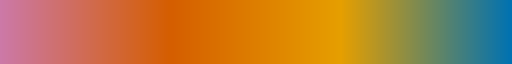

In [27]:
# View colormap 
cmap

### Figure 3: $\chi_\mathrm{p}$, $M$, and $q$

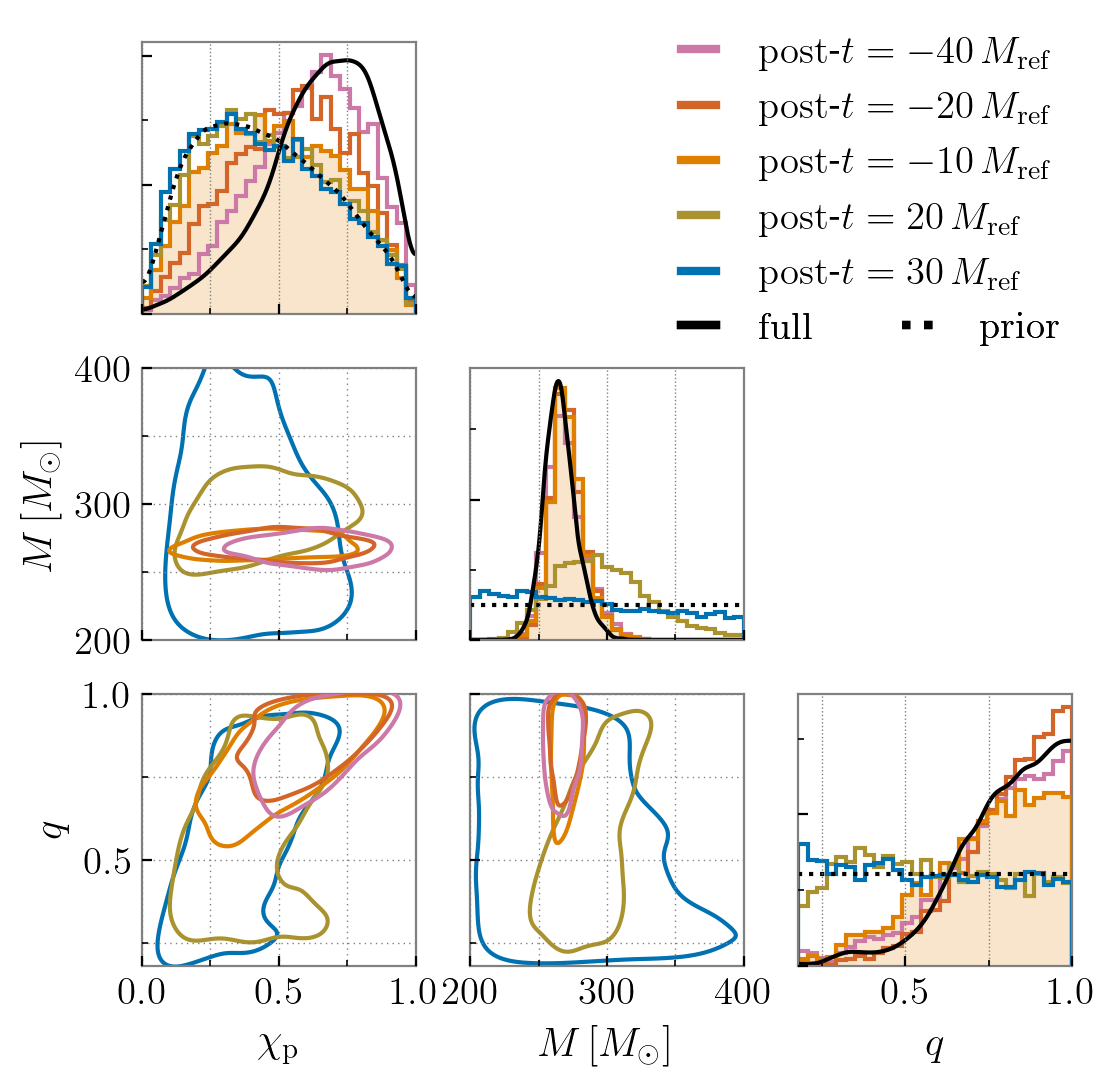

In [28]:
keys = ['chip','mtot','q']    
make_hist(keys, tc_to_plot, 'figure_03', 'post', colors=colors_to_plot)

### Figure 6: $\chi_\mathrm{p}$ and $\chi_\mathrm{eff}$

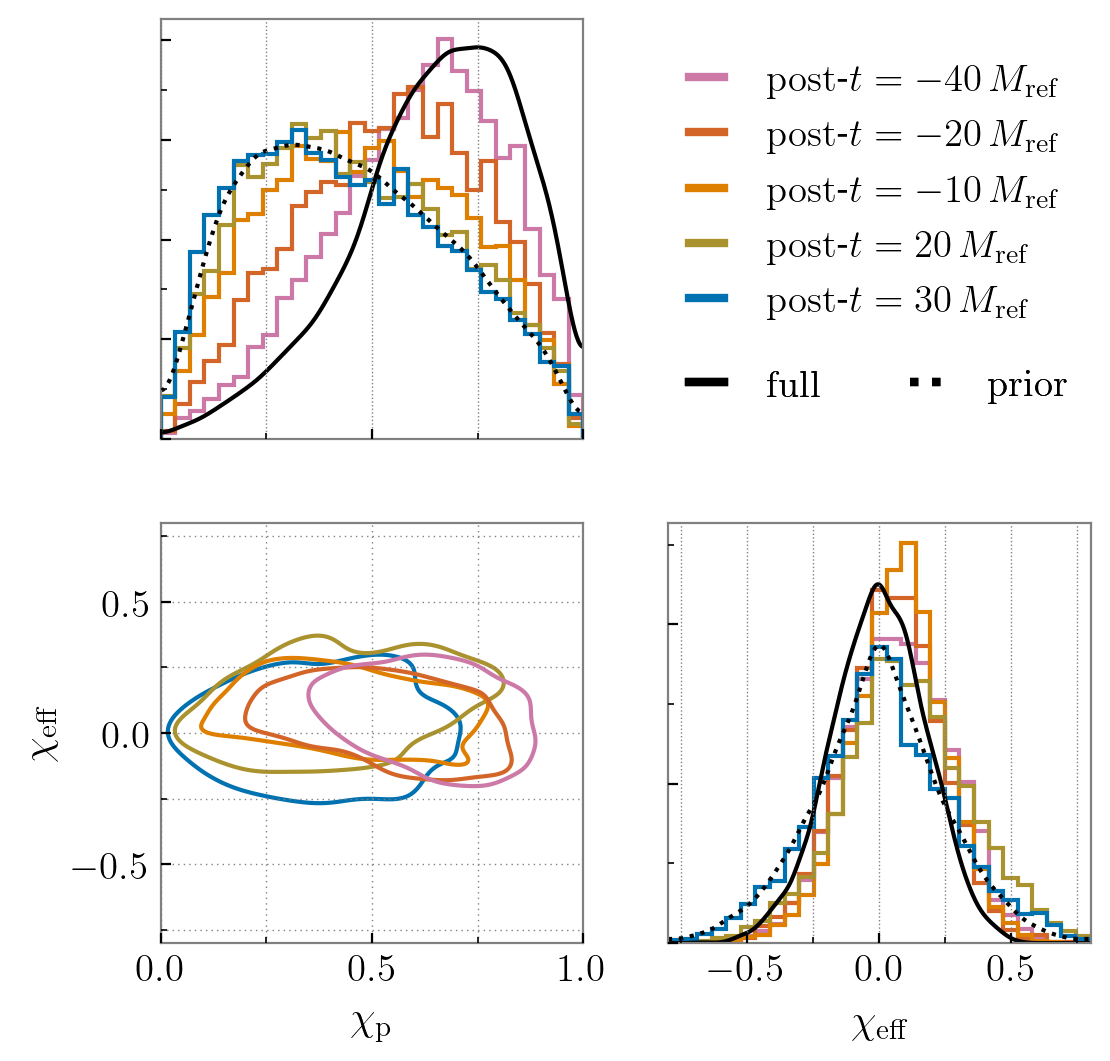

In [29]:
keys = ['chip','chieff']    
make_hist(keys, tc_to_plot, 'figure_06', 'post', colors=colors_to_plot,
          fig_size=(6,6), legend_loc=(-0.06, 1.40), shade=False)